# Relevance Map

## Introduction

This is an experiment to see if we can find a relevance map of a regression model. I got the inspiration from all brain age predictions that have been going around, and I wanted to see if I could come up with a way to visualise the cause of a discrepancy between the predicted and the actual age. The current example is only a proof of concept, and does not use real brain images. 

## Some oversimplified theory

The idea is as follows:
1. Assume images $X = \{x_1, ... x_n\}$, with correspoding true ages $L = \{l_1, ..., l_n\}$.
1. Train a VAE $V$ with encoder $Enc$ and decoder $Dec$ to learn latent representations of $X$. 
1. We map each point $x_i$ to its latent representation $z_i$ using $Enc$. We only take the means, and ignore the variance predicted by $Enc$. We create $Z = \{z_1, ..., z_n\}$.
1. We now train a regression model $R$ to predict $l_i$ from $z_i$. This regression model has loss $L_R$.
1. Making a pipeline of $Enc$ and $R$, we can make a brain age prediction of an image $x$. Using this pipeline, the error in the brain age prediction on image $x_i$ with age $l_i$ is called $E(x_i, l_i)$.  
1. Assume we now see a new image $x_k$ with corresponding age $l_k$. We produce a brain age prediction by first mapping $x_k$ to $z_k$ using $Enc$, and then get the predicted $l_k'$ using $R$.
1. Our prediction is wrong, i.e. $E(x_k, l_k) \neq 0$ and we would like to know what it is that our network saw that caused the wrong prediction. 
1. The idea is to create a new image $x_k^*$, that is similar to $x_k$, but on which the brain age error is smaller. , i.e. $E(x_k^*, l_k) < E(x_k, l_k)$
1. We do this by iteratively updating ${z_k^*}_n \to {z_k^*}_{n+1}$, using the gradient of some loss function. Our loss function consists of three parts. 
    1. The loss of $L_R$ with respect to ${z_k^*}_n$: $L_R$
    2. A distance measure between $z_k$ and ${z_k^*}_n$: $D$
    3. The reciprocal of the standard Gaussian density as ${z_k^*}_n$: $G$
1. All three parts are weighted by their respective factors. 
1. After the optimization procedure has converged, we can use $Dec$ to map ${z_k^*}$ to the image domain. The resulting image should be similar to $x_k$, but still have some important differences. The idea is that those differences are what cause an improvement on the brain age prediction. In that sense, the difference between $x_k$ and $x_k^*$ is the relevance map. 

In [1]:
import os
import pathlib

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.distributions.multivariate_normal import MultivariateNormal

import matplotlib.pyplot as plt
import numpy as np
from sklearn import model_selection

from blobmaker import Blobmaker
from vae import VAE
from regression_model import RegressionModel


In [2]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)
print(device)

cpu


In [8]:
BASE_DIR = os.path.dirname(os.getcwd())
print(BASE_DIR)

/home/stijn/Projects/RelevanceMap


## Step 1: Making blobs

Instead of actual images of brains, in this experiment I will use generated images of some colored blobs. We assume a stochastic process that takes as an input some value $l$, and outputs an image of four blobs. The size and colors of the blobs are sampled randomly around some value determined by $l$. A bigger $l$ produces bigger and brighter blobs, whereas a smaller $l$ produces smaller and darker blobs. Just like in real life.

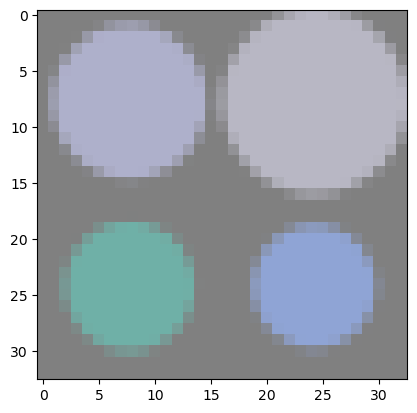

In [15]:
# We make a blobmaker and make it make some blobs
n_blobs = 100
blobby = Blobmaker()
ls = blobby.sample_l(n_blobs)
widths, colors = blobby.sample_widths_and_colors(ls)
blob_images = blobby.make_blob_images(widths, colors)

## Uncomment this if you want to save your data
# with open(f'data/blob_images_{n_blobs}.pkl','wb') as file:
#     pickle.dump(blob_images, file)
# width_columns = {f'width_of_blob_{i}':widths[:,i] for i in range(4)}
# col_columns = {f'color_{j}_of_blob_{i}':colors[:,i,j] for i in range(4) for j in range(3)}
# df = pd.DataFrame({'l':ls, **width_columns, **col_columns})
# df.to_csv(f'data/blob_latents_{n_blobs}.csv')

plt.imshow(np.squeeze(blob_images[0].T))
plt.show()


## Step 2: Making a VAE

I wrote a VAE architecture that works reasonably. I also have a trained set of parameters that you can use. 

In [7]:
trainX, testX, trainL,testL = model_selection.train_test_split(blob_images, ls, test_size=10)
traindata = TensorDataset(torch.FloatTensor(trainX).to(device),torch.FloatTensor(trainL).to(device))
testdata = TensorDataset(torch.FloatTensor(testX).to(device),torch.FloatTensor(testL).to(device))
trainloader = DataLoader(dataset=traindata, batch_size=128, shuffle=True)
testloader = DataLoader(dataset=testdata, batch_size=1, shuffle=False)

In [10]:
indim = (3, 33, 33)
latent_space = 16
vae = VAE(indim=indim, zDim=latent_space).to(device, dtype=torch.float)

<All keys matched successfully>

In [ ]:
lr = 0.0001
optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

In [ ]:
epochs = 200
for epoch in range(epochs):
    epoch_train_kl_loss = 0
    epoch_train_rec_loss = 0
    for imgs, latents in trainloader:
        out, mu, logVar = vae(imgs)
        kl_divergence = torch.mean(0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp(), axis = 1))
        mse_loss = F.mse_loss(out, imgs)
        loss = mse_loss + kl_divergence*1e-6
        # loss = mse_loss
        epoch_train_rec_loss += loss
        epoch_train_kl_loss += kl_divergence
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('Epoch {}: Rec-Loss {}, KL-Loss {}'.format(epoch, epoch_train_rec_loss, epoch_train_kl_loss))

    if epoch%10 == 0:
        with torch.no_grad():
            for i_test, (imgs, latents) in enumerate(testloader):
                out,_,_ = vae(imgs)
                fig, ax = plt.subplots(1,2, figsize=(10,5))
                ax[0].imshow(np.squeeze(out.cpu()).T)
                ax[1].imshow(np.squeeze(imgs.cpu()).T)
                plt.savefig(f'outs/test_{i_test}_epoch{epoch}.png')
                plt.close()
                if i_test >=10:
                    break
                # plt.show()
            for i_train, (imgs, latents) in enumerate(trainloader):
                out,_,_ = vae(imgs)
                fig, ax = plt.subplots(1,2, figsize=(10,5))
                ax[0].imshow(np.squeeze(out.cpu()[0]).T)
                ax[1].imshow(np.squeeze(imgs.cpu()[0]).T)
                plt.savefig(f'outs/train_{i_train}_epoch{epoch}.png')
                plt.close()
                if i_train >= 10:
                    break
                plt.show()

#Epoch 26: Rec-Loss 0.27540716528892517, KL-Loss 43505.85546875



In [ ]:
##  Uncomment this to save the model state dict
# from datetime import datetime
# timestamp = str(datetime.now()).replace(" ","_")
# print(timestamp)
# torch.save(vae.state_dict(), f'drive/MyDrive/RelevanceMap/models/vae_{timestamp}.pkl')

latent_space = 16
indim = (3,33,33)
vae = VAE(indim=indim, zDim=latent_space).to(device, dtype=torch.float)

# I load this one because it works pretty good
statedict = torch.load(os.path.join(BASE_DIR,f'models/vae.pkl'), map_location=torch.device(device))
vae.load_state_dict(statedict)

<All keys matched successfully>

In [ ]:
# Lets randomly plot a few images and their VAE reconstruction
n_plots = 5
shuffle_trainloader = DataLoader(dataset=traindata, batch_size=1, shuffle=True)
i=0
with torch.no_grad():
    for img, latent in shuffle_trainloader:
        fig, ax = plt.subplots(1,2, figsize=(5,3))
        # Plot real image
        ax[0].imshow(np.squeeze(img.cpu().detach().numpy()).T)
        ax[0].set_title('original')
        ax[0].set_xticks([])
        ax[0].set_yticks([])

        out,_,_ = vae(img)
        ax[1].imshow(np.squeeze(out.cpu().detach().numpy()).T)
        ax[1].set_title('reconstructed')
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        plt.tight_layout()
        plt.show()
        if i >= n_plots:
            break
        i +=1

## Step 3: Making a regression model

In [ ]:
from operator import length_hint
# First we need to map all the images to their latent space representation.
# I am going to use the full dataset for this.

zs = np.zeros((n_blobs, latent_space))
full_dataset = TensorDataset(torch.FloatTensor(blob_images), torch.FloatTensor(ls))
no_shuffle_trainloader = DataLoader(dataset=full_dataset, batch_size=128, shuffle=False)

with torch.no_grad():
    start = 0
    for i,(img,_) in enumerate(no_shuffle_trainloader):
        len_i = img.shape[0]
        mu, var = vae.encoder(torch.FloatTensor(img).to(device))
        zs[start:start+len_i] = mu.cpu()
        start = start + len_i


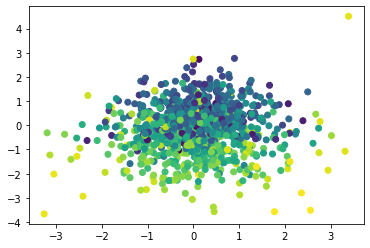

In [ ]:
# The latent space is organized, we clearly see a gradient in z
plt.scatter(zs[:,3], zs[:,2], c=ls)
plt.show()

In [ ]:
# We create a new train/test split including our new latent space representations
trainX, testX, trainL, testL, trainZ, testZ = model_selection.train_test_split(blob_images, ls, zs, test_size=100)
traindataZ = TensorDataset(torch.FloatTensor(trainX).to(device),
                           torch.FloatTensor(trainL).to(device),
                           torch.FloatTensor(trainZ).to(device))
testdataZ = TensorDataset(torch.FloatTensor(testX).to(device),
                           torch.FloatTensor(testL).to(device),
                           torch.FloatTensor(testZ).to(device))
trainloaderZ = DataLoader(dataset=traindataZ, batch_size=128, shuffle=True)
testloaderZ = DataLoader(dataset=testdataZ, batch_size=1, shuffle=False)

In [ ]:
reg = RegressionModel(zDim=latent_space).to(device, dtype=torch.float)

In [ ]:
lr = 0.001
optimizer=torch.optim.Adam(reg.parameters(), lr=lr)

In [ ]:
# train loop
epochs = 200
for epoch in range(epochs):
    train_loss = 0
    for img, latent, z in trainloaderZ:
        out = reg(z)
        loss = F.mse_loss(torch.squeeze(out), latent)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch%10 == 0:
        print(f"Epoch {epoch}/{epochs}, train loss: {train_loss}")

NameError: ignored

In [11]:
reg = RegressionModel(latent_space).to(device, dtype=float).float()
state_dict = torch.load(os.path.join(BASE_DIR,f'models/reg.pkl'), map_location = torch.device(device))
reg.load_state_dict(state_dict)

<All keys matched successfully>

## Step 4: Making a RelevanceMapper

It is time to write the relevance map algorithm

In [123]:
class RelevanceMapper:
    
    def __init__(self, vae, reg):
        self.vae = vae
        self.reg = reg

    def find_relevance_map(self, x, l, pi, iter = 1000, tol = 1e-6):

        with torch.no_grad():
            z,_= self.vae.encoder(torch.FloatTensor(x[None]).to(device))
            # Store copy of z: z*
            z_star,_= self.vae.encoder(torch.FloatTensor(x[None]).to(device))
        z_star.requires_grad = True
        z_dim = z.shape[1]

        # Latent distribution
        z_dist = MultivariateNormal(torch.zeros(z_dim).to(device), torch.eye(z_dim).to(device))

        z_trajectory = []

        l_predictions = []

        l_tensor = torch.squeeze(torch.FloatTensor([l]).to(device))
        lr = 0.001
        optimizer=torch.optim.Adam([z_star], lr=lr)
        # optimizer=torch.optim.SGD([z_star], lr=lr)

        loss1s = []
        loss2s = []
        loss3s = []

        conv_count = 0

        oldloss = np.inf
        # Until convergence (or max iter)
        for epoch in range(iter):
            z_trajectory.append(torch.clone(z_star).detach().cpu().numpy())

            # Get prediction of z*
            l_star = torch.squeeze(self.reg(z_star))

            l_predictions.append(torch.clone(l_star).detach().cpu().numpy().item())

            # Loss 1, prediction error
            loss1 = pi[0] * F.mse_loss(l_star, l_tensor)
            loss1s.append(torch.clone(loss1).cpu().detach().numpy())

            # Loss 2, l2 loss

            # loss2 = pi[1] * F.mse_loss(z, z_star)
            # loss2 = pi[1] * torch.mean(torch.abs((z- z_star)))
            # print(z.shape)
            # print(z_star.shape)
            # print('hello world,',  torch.sqrt(torch.sum(torch.square(z-z_star))))
            loss2 = pi[1] * torch.sqrt(torch.sum(torch.square(z-z_star))+1e-10)
            loss2s.append(torch.clone(loss2).cpu().detach().numpy())

            # Loss 3, Gaussian density loss
            loss3 = pi[2] * -z_dist.log_prob(z_star)
            loss3s.append(torch.clone(loss3).cpu().detach().numpy())

            # Sum them up
            loss = loss1 + loss2 + loss3

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # if epoch%200 == 0:
            #     print(f"{loss.item()}")

            small_enough = torch.abs(loss-oldloss) < tol
            if small_enough:
                conv_count += 1
                if conv_count >= 5:
                    print("tolerance reached")
                    break
            else:
                conv_count = 0
            oldloss = loss

        z_trajectory.append(torch.clone(z_star).detach().cpu().numpy())

        # plt.plot(loss1s, label="Regression loss")
        # plt.plot(loss2s, label="L2 distance loss")
        # plt.plot(loss3s, label="Gaussian Loss")


        # plt.legend()
        # plt.show()
        # plt.plot(np.array(l_predictions))
        # plt.plot(l*np.ones_like(np.array(l_predictions)))
        # plt.show()


        # z_traj_numpy = np.squeeze(np.stack(z_trajectory))
        # plt.plot(z_traj_numpy[:,0], z_traj_numpy[:,1])
        # # print(z_traj_numpy.shape)
        # # plt.xlim(-3,3)
        # # plt.ylim(-3,3)
        # plt.show()


        with torch.no_grad():
            reconstructed = vae.decoder(z_star)
            out_im = np.squeeze(reconstructed.detach().cpu().numpy()).T
            diff = out_im-x.T

        return diff, z_trajectory, [loss1s, loss2s, loss3s]



[0.37409122]
[0.07804797 0.14360558 0.1318814  0.12385104]
[[0.48647943 0.32342354 0.32619962]
 [0.14805729 0.35871794 0.32722445]
 [0.23733701 0.27274644 0.47352096]
 [0.49187558 0.22478048 0.47071665]]


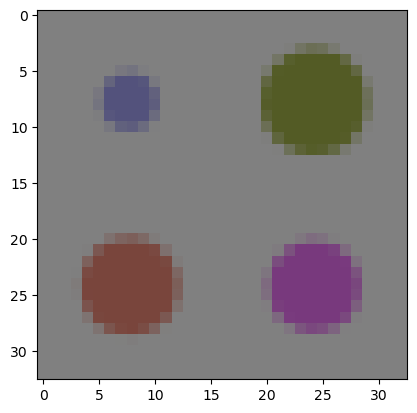

In [148]:
true_l = blobby.sample_l(1)
# true_l = 0.2
# l = 0.5
print(true_l)
widths, colors = blobby.sample_widths_and_colors(true_l)
print(widths)
print(colors)
this_blob = blobby.make_blob_image(widths, colors)/255
plt.imshow(this_blob)

tolerance reached


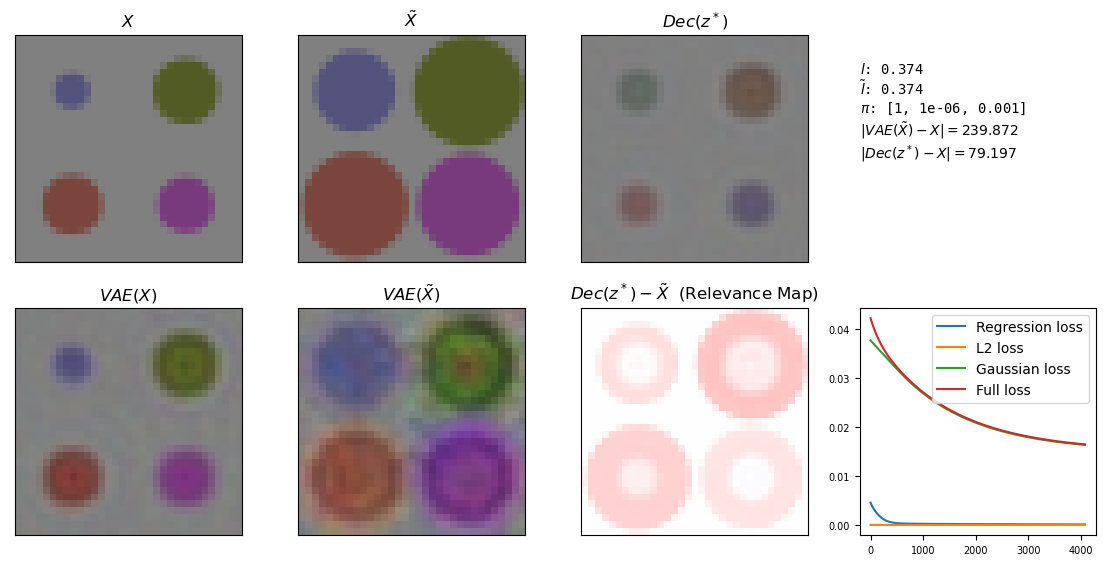

In [166]:
altered_l = true_l
widths_altered = widths.copy()
colors_altered = colors.copy()
widths_altered +=0.1

this_blob_altered = blobby.make_blob_image(widths_altered, colors_altered)/255

# Find relevance map
rmap = RelevanceMapper(vae, reg)
pi = [1, 0.000001, 0.001] ############################################PI
img, z_trajectory, losses = rmap.find_relevance_map(this_blob_altered.T, altered_l, pi, iter = 10000, tol = 1e-6)

fig, ax = plt.subplots(2,4, figsize=(14,6.5))
this_blob = blobby.make_blob_image(widths, colors)/255

# Draw original and reconstruction
ax[0,0].imshow(this_blob)
ax[0,0].set_title('$X$')

with torch.no_grad():
    rec= np.squeeze(vae(torch.FloatTensor(this_blob.T[None]).to(device))[0].cpu().detach().numpy()).T
    ax[1,0].imshow(rec )
    ax[1,0].set_title('$VAE(X)$')

# Draw altered version and reconstruction
ax[0,1].imshow(this_blob_altered)
ax[0,1].set_title('$\\tilde{X}$')

with torch.no_grad():
    rec= np.squeeze(vae(torch.FloatTensor(this_blob_altered.T[None]).to(device))[0].cpu().detach().numpy()).T
    ax[1,1].imshow(rec)
    ax[1,1].set_title('$VAE(\\tilde{X})$')

# Draw z* reconstruction and relevance map
out_img = vae.decoder(torch.FloatTensor(z_trajectory[-1]).to(device)).cpu().detach().numpy().squeeze().T
ax[0,2].imshow(out_img)
ax[0,2].set_title('$Dec(z^*)$')

ax[1,2].imshow(img.mean(axis=2), cmap="bwr", vmin=-1, vmax=1)
ax[1,2].set_title('$Dec(z^*)-\\tilde{X}$  (Relevance Map)')

for axs in ax.flatten()[:7]:
    axs.set_xticks([])
    axs.set_yticks([])

ax[0,3].set_axis_off()

# Draw losses
ax[1,3].plot(losses[0],label='Regression loss')
ax[1,3].plot(losses[1],label='L2 loss')
ax[1,3].plot(losses[2],label='Gaussian loss')
full_loss = [losses[0][i]+losses[1][i]+losses[2][i] for i in range(len(losses[0]))]
ax[1,3].plot(full_loss,label='Full loss')
ax[1,3].legend()

txt = \
f"""
$l$: {np.round(true_l,3).item()}
$\\tilde{{l}}$: {np.round(altered_l,3).item()}
$\pi$: {pi}
$|VAE(\\tilde{{X}}) - X| = {np.round(np.sum(np.abs(rec-this_blob)),3)}$
$|Dec(z^*) - X| = {np.round(np.sum(np.abs(out_img-this_blob)),3)}$

"""

ax[0,3].text(0,0.3, txt, family='monospace')

# plt.tight_layout()
# ax[1,3].set_yticks(ax[1,3].get_yticks(),fontsize=1)
ax[1,3].tick_params(labelsize=7)
plt.show()